In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('./data/tiny_sample_data.csv')

In [3]:
data

,time_ms,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,orientation_w,orientation_x,orientation_y,orientation_z,Date,Position,Coarse_label,Fine_label,Segment,User
0,1.498121e+12,-10.223242,-4.031835,-4.865018,-0.390958,0.456892,-0.517477,0.082608,0.579526,0.810031,-0.033991,220617,Hand,2.0,5.0,1,User1
1,1.498121e+12,-9.102754,-1.781286,-8.078036,0.342843,-1.087437,1.090648,0.175092,0.527139,0.828302,-0.073106,220617,Hand,2.0,5.0,1,User1
2,1.498121e+12,-7.067683,-3.792415,-12.239159,1.641834,-3.020055,-3.591452,0.247089,0.381125,0.852983,-0.256846,220617,Hand,2.0,5.0,1,User1
3,1.498121e+12,-8.844416,-0.181914,-11.118354,1.025997,-2.625678,-1.296871,0.430142,0.219153,0.741506,-0.465945,220617,Hand,2.0,5.0,1,User1
4,1.498121e+12,3.179461,0.718264,-9.935942,-3.889429,5.263189,1.311569,0.225644,0.255715,0.823396,-0.453160,220617,Hand,2.0,5.0,1,User1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68836,1.497460e+12,-9.368783,-2.587768,0.192931,-0.129918,0.080427,-0.304560,0.384867,-0.676317,0.228131,0.585172,140617,Torso,2.0,5.0,34,User3
68837,1.497460e+12,-8.193694,-1.666364,0.753842,-0.528795,-0.085802,0.065608,0.367071,-0.672108,0.218054,0.604961,140617,Torso,2.0,5.0,34,User3
68838,1.497460e+12,-9.632220,-1.501508,1.749135,0.109280,-0.347863,0.169926,0.389664,-0.652718,0.251713,0.598966,140617,Torso,2.0,5.0,34,User3
68839,1.497460e+12,-9.561332,-2.722536,-1.511116,-0.507558,0.180567,0.434380,0.329911,-0.694583,0.243898,0.590950,140617,Torso,2.0,5.0,34,User3


In [4]:
data.groupby(['User', 'Position'])['Segment'].count()

User   Position
User1  Bag         6190
       Hand        6191
       Hips        6190
       Torso       6190
User2  Bag         7020
       Hand        7020
       Hips        7020
       Torso       7020
User3  Bag         4000
       Hand        4000
       Hips        4000
       Torso       4000
Name: Segment, dtype: int64

In [5]:
data.query('User == "User1"').groupby('Segment')[['User']].count()

,User
Segment,
1,164
2,104
3,352
4,176
5,1792
6,1144
7,1656
8,1429
9,952


In [6]:
a = data.query('User == "User1"').groupby('Coarse_label')[['Segment']].nunique()
a['Count'] = data.query('User == "User1"').groupby('Coarse_label')['Segment'].count().values
a

,Segment,Count
Coarse_label,,
1.0,7,3444
2.0,9,2777
3.0,1,612
4.0,4,2140
5.0,3,4400
6.0,5,4172
7.0,2,3612
8.0,2,3604


# Preprocessing #1
Let's create more journeys (sub-segments) from each of the main segments using windows. From our reference paper, we're going to sample using a sliding fixed window of 2.56secs and 50% overlap

Data was downsampled to 5Hz i.e. 5 datapoints per second. Therefore our window should cover;
$$2.56~*~5 = 12$$

So the idea is to create new data for each segment for each user. 

-----
UPDATE:\
Instead of going with 2.56secs which results in a meager 12 datapoints, I'll go with 128datapoints so as to capture more information due to the low sampling rate, 
$$x~*~5 = 128$$
$$x=25.6secs$$


In [7]:
# Define the window size and overlap
#window_size = 12  # 2.56 seconds * 5 Hz = 12 datapoints
window_size = 128  # 25.6 seconds for my 5 Hz = 12 datapoints
overlap = 0.5  # 50% overlap
step_size = int(window_size * (1 - overlap))  # Calculate the step size based on the overlap

# Path to the combined dataset
input_file = './data/tiny_sample_data.csv'
output_file = './data/sample_sub_segmented_data.csv'

# Function to create sub-segments using sliding window
def create_sub_segments(data, window_size, step_size):
      sub_segments = []
      for (user, position), user_position_data in data.groupby(['User', 'Position']):
            sub_segment_id = 1
            for segment, segment_data in user_position_data.groupby('Segment'):
                  for start in range(0, len(segment_data) - window_size + 1, step_size):
                        end = start + window_size
                        sub_segment = segment_data.iloc[start:end].copy()
                        sub_segment['Sub_Segment'] = sub_segment_id
                        sub_segments.append(sub_segment)
                        sub_segment_id += 1
      return pd.concat(sub_segments).reset_index(drop=True)

In [8]:
# # Read the entire dataset
data = pd.read_csv(input_file)

# Create sub-segments
sub_segmented_data = create_sub_segments(data, window_size, step_size)

# Save the sub-segmented data
sub_segmented_data.to_csv(output_file, index=False, header=True)

print(f"Sub-segmented data has been saved to '{output_file}'")

Sub-segmented data has been saved to './data/sample_sub_segmented_data.csv'


____

In [1]:
import pandas as pd
import numpy as np

In [2]:
subbed_data = pd.read_csv('./data/sample_sub_segmented_data.csv')

In [3]:
subbed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75264 entries, 0 to 75263
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time_ms         75264 non-null  float64
 1   acceleration_x  75264 non-null  float64
 2   acceleration_y  75264 non-null  float64
 3   acceleration_z  75264 non-null  float64
 4   gyroscope_x     75264 non-null  float64
 5   gyroscope_y     75264 non-null  float64
 6   gyroscope_z     75264 non-null  float64
 7   orientation_w   75264 non-null  float64
 8   orientation_x   75264 non-null  float64
 9   orientation_y   75264 non-null  float64
 10  orientation_z   75264 non-null  float64
 11  Date            75264 non-null  int64  
 12  Position        75264 non-null  object 
 13  Coarse_label    75264 non-null  float64
 14  Fine_label      75264 non-null  float64
 15  Segment         75264 non-null  int64  
 16  User            75264 non-null  object 
 17  Sub_Segment     75264 non-null 

In [4]:
subbed_data

,time_ms,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,orientation_w,orientation_x,orientation_y,orientation_z,Date,Position,Coarse_label,Fine_label,Segment,User,Sub_Segment
0,1.498123e+12,4.155323,-3.489487,-8.427376,-0.061924,-0.015004,-0.012025,0.252894,-0.812452,-0.517429,-0.090730,220617,Bag,5.0,9.0,5,User1,1
1,1.498123e+12,4.202374,-3.341170,-8.193485,-0.027076,-0.044613,0.000945,0.248267,-0.813363,-0.518218,-0.090835,220617,Bag,5.0,9.0,5,User1,1
2,1.498123e+12,4.211212,-2.990762,-7.968981,-0.007993,-0.022988,-0.003106,0.243827,-0.813995,-0.518773,-0.093983,220617,Bag,5.0,9.0,5,User1,1
3,1.498123e+12,3.775043,-2.472958,-9.199511,-0.017072,-0.012406,-0.002976,0.231545,-0.816729,-0.519620,-0.096611,220617,Bag,5.0,9.0,5,User1,1
4,1.498123e+12,3.824320,-2.127032,-8.962121,0.007111,0.038406,-0.010212,0.226447,-0.816977,-0.521040,-0.098922,220617,Bag,5.0,9.0,5,User1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75259,1.497457e+12,-9.458488,-0.253626,1.659569,0.147087,0.254970,0.078766,0.495246,-0.508980,0.391481,0.585160,140617,Torso,7.0,15.0,33,User3,36
75260,1.497457e+12,-9.493943,-0.562109,1.640557,-0.056868,0.013105,0.073541,0.491262,-0.511190,0.390414,0.587300,140617,Torso,7.0,15.0,33,User3,36
75261,1.497457e+12,-9.490616,-0.482229,1.615680,-0.044639,-0.080616,-0.032349,0.495556,-0.508778,0.380982,0.591962,140617,Torso,7.0,15.0,33,User3,36
75262,1.497457e+12,-9.532318,-0.632069,2.027496,-0.075744,-0.100185,-0.034209,0.500004,-0.506685,0.368966,0.597602,140617,Torso,7.0,15.0,33,User3,36


### Feature Extraction for LSTM
Idea is to go through the dataset and create a feature vector like;

|$a_x$|$a_y$|$a_z$|$w_x$|$w_y$|$w_z$|$Label$|
|--|--|--|--|--|--|--|
|128 vector|128 vector|128 vector|128 vector|128 vector|128 vector|1 vector|

We already achieved the windowing as described in the paper. So what we can do is that for each subsegment, we take the 128 and it's corresponding label and then move over to the next 128.

** EDIT **

This changed from 12 to 128 to better suite the paper

In [5]:
a = np.arange(240*5)

start=0
window = 128
for i in range(0, int(len(a)/window), 1):
      end = start + window
      print(len(a[start:end]))
      start = end

128
128
128
128
128
128
128
128
128


What I want to do is to initialize a numpy array of the same shape as expected after extracting features from this dataset. Its length should be the length of the dataset divided by 12

In [6]:
start=0
window = 128

# create empty numpy array of anticipated shape
lstm_features = np.empty((int(len(subbed_data)/window), 7), dtype=object)

for i in range(0, int(len(subbed_data)/window), 1):
      end = start + window
      chunk = subbed_data.iloc[start:end, :]
      lab_list = np.unique(chunk['Coarse_label'].values)

      lstm_features[i][0] = chunk.iloc[:,1].values    # acceleration_x
      lstm_features[i][1] = chunk.iloc[:,2].values    # acceleration_y
      lstm_features[i][2] = chunk.iloc[:,3].values    # acceleration_z
      lstm_features[i][3] = chunk.iloc[:,4].values    # gyroscope_x
      lstm_features[i][4] = chunk.iloc[:,5].values    # gyroscope_y
      lstm_features[i][5] = chunk.iloc[:,6].values    # gyroscope_z
      lstm_features[i][6] = lab_list[0]   # coarse_label

      del chunk
      start = end

In [7]:
lstm_features

array([[array([4.155323, 4.202374, 4.211212, 3.775043, 3.82432 , 3.377523,
               3.435321, 3.983415, 3.64903 , 4.387066, 3.810887, 4.053947,
               3.612541, 3.694567, 3.439902, 3.737407, 3.571662, 3.845668,
               3.267562, 3.311745, 3.53546 , 4.039094, 3.048667, 3.639187,
               3.758294, 3.59442 , 3.433584, 3.601121, 3.371949, 3.227835,
               4.213177, 3.153479, 3.296918, 2.552695, 2.932214, 2.553286,
               3.455318, 4.759464, 2.648059, 2.215393, 3.032727, 2.113679,
               3.085481, 3.492652, 3.207509, 3.615286, 4.341299, 5.569077,
               4.317497, 5.09294 , 4.91299 , 4.187136, 5.697829, 5.895407,
               5.246243, 4.903185, 6.650383, 6.969932, 4.716992, 6.728574,
               5.819197, 5.247669, 5.124879, 5.816632, 6.038923, 4.993093,
               5.899301, 5.380441, 5.449041, 3.77587 , 5.437661, 4.21345 ,
               3.105508, 3.766747, 5.101131, 4.49782 , 5.545311, 3.682519,
               3.906246, 

In [8]:
len(lstm_features)

588

In [9]:
del lstm_features

### Feature Extraction for CNN-RNN
We need to get the longitudinal acceleration, transversal acceleration and angular velocity for this data before we look to apply the 1D to 2D mapping

* What's the idea for this again? Remember that our journeys are the sub-segments

In [10]:
subbed_data.query("Position == 'Bag' & User == 'User1'").groupby('Coarse_label')[['Segment','Sub_Segment']].nunique()

,Segment,Sub_Segment
Coarse_label,,
1.0,2,8
2.0,1,4
3.0,1,1
4.0,3,3
5.0,3,13
6.0,3,9
7.0,2,11
8.0,2,11


In [11]:
subbed_data.query("Coarse_label == 5.0").groupby('User')[['Segment','Sub_Segment']].nunique()

,Segment,Sub_Segment
User,,
User1,3,13
User2,4,21


In [12]:
subbed_data.query("Coarse_label == 5.0 & Position=='Hand'").groupby(['User','Segment'])[['Sub_Segment']].count()

Sub_Segment
User  Segment             
User1 5                768
      7                640
      9                256
User2 64              1536
      66               128
      70               512
      73               512

In [13]:
a = pd.read_csv('./data/train_data_User3.csv')

In [14]:
a['Coarse_label'].value_counts()

Coarse_label
7.0    246300
1.0    183898
2.0    159313
4.0     51904
Name: count, dtype: int64

In [15]:
del a

It seems like User 3 has no driving data. This looks like it might present a problem. I'll have to download an additional dataset an add to this. For now, ignore this as this User 3 driving won't be predicted. Seeing as the additional data is a mixture of User2 and User3, it can be added in as unsupervised learning if time permits. For now, kindly forge ahead and let Johan know. http://www.shl-dataset.org/activity-recognition-challenge-2020/

Problem can be binary for now i.e. the CNN and RNN part. LSTM doesn't really care if its missing as it doesn't take driver detail into consideration.

To continue with the feature extractor for this CNN-GRU part, we need to get the longitudinal and transversal acceleration from the $acc_x$, $acc_y$, and $acc_z$. To get that, I'll need to get the rotation matrix for every subsection??

* My next question/confusion was related to how journeys are understood for this task. Given that this is a multi-task problem, I would want to retain the fact that the journeys are split this way. I mean, the purpose of research is to try out new things. Failure is also a good result. 
* As a result the plan is to transform the sub-segment journeys to long acc, tranv acc and ang vel and then convert those to 2D. No need for windows seeing as these subjourneys were already windowed. You get?


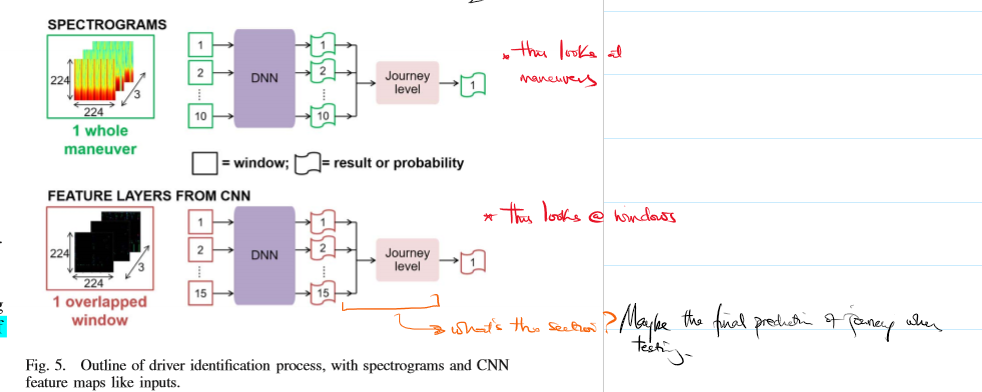

#### Getting the Euler's angles from the Quaternions

$$\varphi=\arctan{\left( \frac{2(q_1q_0+q_2q_3)}{q_0^2-q_1^2-q_2^2+q_3^2} \right)}$$

$$ \theta=-\arcsin(2(q_1q_3-q_2q_0))$$

$$\psi=\arctan{\left( \frac{2(q_3q_0+q_1q_2)}{q_0^2+q_1^2-q_2^2-q_3^2} \right)}$$



In [16]:
def euler_from_quaternions(q):
      '''
      Gets the Euler angles (roll, pitch and yaw) from quaternions using (ZYX notation)
      Input:
         q: Array which contains orientation coordinates w, x, y, z which corresponds to (q0, q1, q2, q3)
      Output:
         roll, pitch, and yaw in degrees
      '''
      q0, q1, q2, q3 = q

      # Roll (x-axis rotation)
      roll = np.arctan2(2 * (q1 * q0 + q2 * q3), q0**2 - q1**2 - q2**2 + q3**2)

      # Pitch (y-axis rotation)
      pitch = -np.arcsin(2 * (q1 * q3 - q2 * q0))

      # Yaw (z-axis rotation)
      yaw = np.arctan2(2 * (q3 * q0 + q1 * q2), q0**2 + q1**2 - q2**2 - q3**2)

      return np.degrees(roll), np.degrees(pitch), np.degrees(yaw)


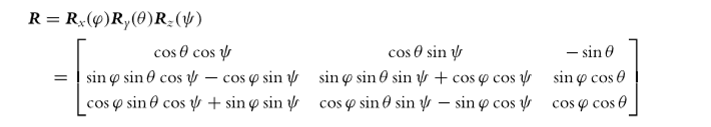

In [17]:
def get_rot_from_euler(sub_segment):
      roll_pitch_yaw_df = sub_segment.apply(euler_from_quaternions, axis=1, result_type='expand')
      roll, pitch, yaw = roll_pitch_yaw_df.median()
      
      # rotation matrix
      R = np.array([
                  [(np.cos(pitch)* np.cos(yaw)), (np.cos(pitch) * np.sin(yaw)), -np.sin(pitch)],
                  [((np.sin(roll)*np.sin(pitch)*np.cos(yaw)) - (np.cos(roll)*np.sin(yaw))), ((np.sin(roll)*np.sin(pitch)*np.sin(yaw)) + (np.cos(roll) * np.cos(yaw))), (np.sin(roll) * np.cos(pitch))],
                  [((np.cos(roll)*np.sin(pitch)*np.cos(yaw)) + (np.sin(roll)*np.sin(yaw))), ((np.cos(roll)*np.sin(pitch)*np.sin(yaw)) - (np.sin(roll) * np.cos(yaw))), (np.cos(roll) * np.cos(pitch))]
                  ])

      return R

Let's try out the other method;

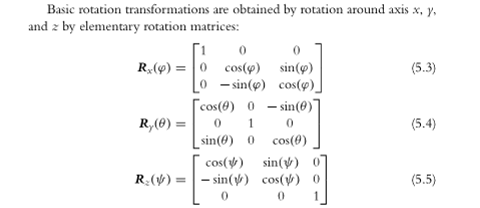

In [18]:
def get_rot_from_euler2(sub_segment):
      roll_pitch_yaw_df = sub_segment.apply(euler_from_quaternions, axis=1, result_type='expand')
      roll, pitch, yaw = roll_pitch_yaw_df.median()
      
      # rotation matrix
      Rx = np.array([
                    [1, 0, 0],
                    [0, np.cos(roll), np.sin(roll)],
                    [0, -np.sin(roll), np.cos(roll)]
                    ])
      Ry = np.array([
                    [np.cos(pitch), 0, -np.sin(pitch)],
                    [0, 1, 0],
                    [np.sin(pitch), 1, np.cos(pitch)]
                    ])
      Rz = np.array([
                    [np.cos(yaw), np.sin(yaw), 0],
                    [-np.sin(yaw), np.cos(yaw), 0],
                    [0, 0, 1]
                    ])
      
      R = Rx @ Ry @ Rz

      return R

There's actually no need to convert this to Euler angles instead we can just get the Rotation Matrix (ZYX) from it

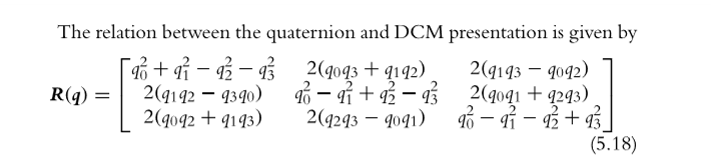

This means, you'll have to take the median of the quartenions for each subsegment and apply the rotation matrix to rotate that.

In [19]:
def quaternion_to_rotation_matrix_zyx(q):
      '''
      Get rotation matrix (ZYX notation) from quaternion
      Input:
         q: Array which contains orientation coordinates w, x, y, z which corresponds to (q0, q1, q2, q3)
      Output:
         rotation matrix (ZYX notation), numpy array
      '''
      q0, q1, q2, q3 = q

      # rotation matrix
      R = np.array([
                  [(q0**2 + q1**2 - q2**2 - q3**2), 2*(q0*q3 + q1*q2), 2*(q1*q3 - q0*q2)],
                  [2*(q1*q2 - q3*q0), (q0**2 - q1**2 + q2**2 - q3**2), 2*(q0*q1 + q2*q3)],
                  [2*(q0*q2 + q1*q3), 2*(q2*q3 - q0*q1), (q0**2 - q1**2 - q2**2 + q3**2)]
                  ])

      return R

def get_rotation_matrix_sub_segment(sub_segment):
      '''
      For each sub_segment or sub_journey, we estimate the median quaternion and use it to create our rotation matrix
      Input:
            sub_segment: Array containing orientation coordinates w, x, y, z for sub_segment. Expected shape
                         is (len(sub_segment), 4)
      Output:
            rotation matrix (ZYX notation). numpy array
      '''
      q = sub_segment.median()

      R = quaternion_to_rotation_matrix_zyx(q)

      return R
      

**You know, for now, we'll have to stick with using the Euler angles to derive our rotation matrix because I don't think getting using the median of the quaternion and the median of the Euler angles will result in the same rotation matrix. As a result, this might cause some problems. For now, we stick with euler angles**

In [20]:
subbed_data.query("User == 'User1' & Position == 'Hand' & Coarse_label==5.0")['Sub_Segment'].unique()

array([ 1,  2,  3,  4,  5,  6, 10, 11, 12, 13, 14, 19, 20], dtype=int64)

In [21]:
get_rotation_matrix_sub_segment(subbed_data.query("User == 'User1' & Sub_Segment == 10 & Position == 'Hand'").iloc[:,7:11])

array([[ 0.60178655, -0.06145368, -0.60197675],
       [ 0.56750119,  0.35194186,  0.53139339],
       [ 0.20998798, -0.77502257,  0.28904095]])

In [22]:
get_rot_from_euler(subbed_data.query("User == 'User1' & Sub_Segment == 10 & Position == 'Hand'").iloc[:,7:11])

array([[ 0.28512279, -0.18950186,  0.9395712 ],
       [-0.94839015, -0.19771376,  0.24792216],
       [ 0.13878444, -0.96176833, -0.23609439]])

In [23]:
get_rot_from_euler2(subbed_data.query("User == 'User1' & Sub_Segment == 10 & Position == 'Hand'").iloc[:,7:11])

array([[ 0.28512279, -0.18950186,  0.9395712 ],
       [-0.5475427 ,  0.4053977 ,  0.24792216],
       [-0.24293956, -1.5361068 , -0.23609439]])

Slightly different values but later on, I'll check to see why

-----------

* For each sub_segment,
   - get the rotation matrix
   - apply to sub_segment and get long acc and transv acc
   - get the magnitude of the gyro measurements --> angular velocity

In [24]:
subbed_data

,time_ms,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,orientation_w,orientation_x,orientation_y,orientation_z,Date,Position,Coarse_label,Fine_label,Segment,User,Sub_Segment
0,1.498123e+12,4.155323,-3.489487,-8.427376,-0.061924,-0.015004,-0.012025,0.252894,-0.812452,-0.517429,-0.090730,220617,Bag,5.0,9.0,5,User1,1
1,1.498123e+12,4.202374,-3.341170,-8.193485,-0.027076,-0.044613,0.000945,0.248267,-0.813363,-0.518218,-0.090835,220617,Bag,5.0,9.0,5,User1,1
2,1.498123e+12,4.211212,-2.990762,-7.968981,-0.007993,-0.022988,-0.003106,0.243827,-0.813995,-0.518773,-0.093983,220617,Bag,5.0,9.0,5,User1,1
3,1.498123e+12,3.775043,-2.472958,-9.199511,-0.017072,-0.012406,-0.002976,0.231545,-0.816729,-0.519620,-0.096611,220617,Bag,5.0,9.0,5,User1,1
4,1.498123e+12,3.824320,-2.127032,-8.962121,0.007111,0.038406,-0.010212,0.226447,-0.816977,-0.521040,-0.098922,220617,Bag,5.0,9.0,5,User1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75259,1.497457e+12,-9.458488,-0.253626,1.659569,0.147087,0.254970,0.078766,0.495246,-0.508980,0.391481,0.585160,140617,Torso,7.0,15.0,33,User3,36
75260,1.497457e+12,-9.493943,-0.562109,1.640557,-0.056868,0.013105,0.073541,0.491262,-0.511190,0.390414,0.587300,140617,Torso,7.0,15.0,33,User3,36
75261,1.497457e+12,-9.490616,-0.482229,1.615680,-0.044639,-0.080616,-0.032349,0.495556,-0.508778,0.380982,0.591962,140617,Torso,7.0,15.0,33,User3,36
75262,1.497457e+12,-9.532318,-0.632069,2.027496,-0.075744,-0.100185,-0.034209,0.500004,-0.506685,0.368966,0.597602,140617,Torso,7.0,15.0,33,User3,36


In [25]:
position = 'Hand'
user = 'User1'
len(subbed_data.query('Coarse_label == 5.0'))/128

136.0

In [26]:
subbed_data.groupby(['User', 'Position', 'Sub_Segment']).count()['Coarse_label'].unique()

array([128], dtype=int64)

I was thinking of looping through each user, position, segment and then sub-segment but that's not efficient. I already know that each subsegment has 12 data points, why don't I just look at 12 data points like I did in the LSTM section? 

EDIT: It is now 128pts but same principle

In [27]:
# add long_acc, tranv_acc and ang_vel to columns
def add_transf_cols(data):
      data['long_acc'] = np.nan
      data['tranv_acc'] = np.nan
      data['ang_vel'] = np.nan

      return data

In [28]:
int(128/2)

64

In [29]:
subbed_data = add_transf_cols(subbed_data)

However, since my window is 128 and that's 25.6 secs, I'll have to take the median after ever 12.8 secs;

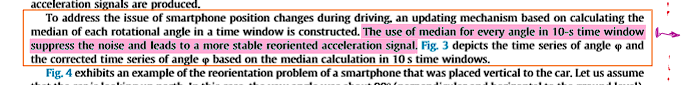
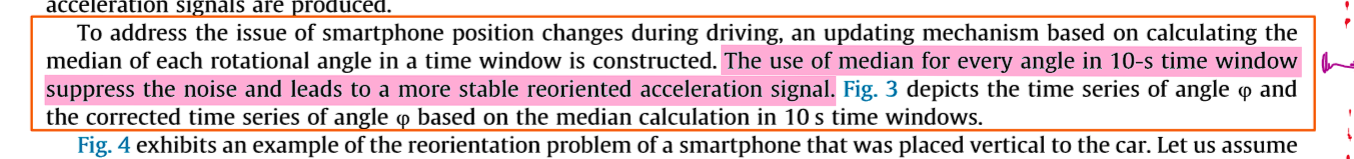

In [30]:
def rotate_acc_to_global_coord(data, window=None):
      '''
      Takes the dataset (where coarse_label == 5.0) and for each sub_segment, it get's the rotation matrix 
      (using the orientation sensor data), to rotate the accelerometer triaxal data to the global coordinates.
      Input:
            data: dataframe with appropriate labels
            window: the number of datapoints in each sub-segment
      Output:
            dataframe with appended columns (longitudinal acceleration, transversal acceleration corresponding to a'_x, a'_y)
      '''
      if window is None:
            window = data.groupby(['User', 'Position', 'Sub_Segment']).count()['Coarse_label'].unique()[0]
      
      ### The idea here is to halve the window (128) to 64 so as to adhere to info above;
      window = int(window/2)

      # get idx of columns in df
      cols = ['acceleration_x', 'acceleration_y', 'acceleration_z',
              'orientation_w', 'orientation_x', 'orientation_y', 'orientation_z']
      col_idx = [data.columns.get_loc(col) for col in cols]

      start = 0
      for i in range(0, int(len(data)/window), 1):
            end = start + window
            chunk = data.iloc[start:end, col_idx].copy() # gives me the needed columns

            # get rotation matrix and rotate acc vals to global coord
            R = get_rot_from_euler(chunk.iloc[:,3:]) # sends in only the orientation data and results in rotation matrix
            long_acc, tranv_acc = (chunk.iloc[:,:3] @ R)[0], (chunk.iloc[:,:3] @ R)[1]

            # attach values to df
            repl_idx_long = data.columns.get_loc('long_acc')
            repl_idx_tranv = data.columns.get_loc('tranv_acc')
            data.iloc[start:end, repl_idx_long] = long_acc
            data.iloc[start:end, repl_idx_tranv] = tranv_acc

            del chunk, long_acc, tranv_acc
            start = end

      return data

def get_angular_vel_from_gyr(data):
      '''
      Takes the dataset (where coarse_label == 5.0) and get's the angular velocity which corresponds to the square root of the sum of the
      squared gyroscope measurements
      Input:
            dataframe with appropriate labels
      Output:
            dataframe with appended columns (ang_vel)
      '''
      # get idx of columns in df
      cols = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z']
      #col_idx = [data.columns.get_loc(col) for col in cols]
      
      # simply the sqrt of the sum of the squared gyro measurements
      ang_vel = np.sqrt(np.sum(data[cols]**2, axis=1))
      data['ang_vel'] = ang_vel

      return data

In [31]:
def get_long_tranv_angl(data):
      '''Gets the longitudinal acc, tranversal acc and angular velocity for coarse label == 5.0'''
      idx = data.query('Coarse_label == 5.0').index

      modified_data = get_angular_vel_from_gyr(rotate_acc_to_global_coord(data.loc[idx, :]))
      data.loc[idx, :] = modified_data

      return data

In [32]:
subbed_data = get_long_tranv_angl(subbed_data)

In [33]:
subbed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75264 entries, 0 to 75263
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time_ms         75264 non-null  float64
 1   acceleration_x  75264 non-null  float64
 2   acceleration_y  75264 non-null  float64
 3   acceleration_z  75264 non-null  float64
 4   gyroscope_x     75264 non-null  float64
 5   gyroscope_y     75264 non-null  float64
 6   gyroscope_z     75264 non-null  float64
 7   orientation_w   75264 non-null  float64
 8   orientation_x   75264 non-null  float64
 9   orientation_y   75264 non-null  float64
 10  orientation_z   75264 non-null  float64
 11  Date            75264 non-null  int64  
 12  Position        75264 non-null  object 
 13  Coarse_label    75264 non-null  float64
 14  Fine_label      75264 non-null  float64
 15  Segment         75264 non-null  int64  
 16  User            75264 non-null  object 
 17  Sub_Segment     75264 non-null 

In [34]:
subbed_data#.query('Coarse_label == 5.0')

,time_ms,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,orientation_w,orientation_x,orientation_y,...,Date,Position,Coarse_label,Fine_label,Segment,User,Sub_Segment,long_acc,tranv_acc,ang_vel
0,1.498123e+12,4.155323,-3.489487,-8.427376,-0.061924,-0.015004,-0.012025,0.252894,-0.812452,-0.517429,...,220617,Bag,5.0,9.0,5,User1,1,-0.432516,6.379768,0.064841
1,1.498123e+12,4.202374,-3.341170,-8.193485,-0.027076,-0.044613,0.000945,0.248267,-0.813363,-0.518218,...,220617,Bag,5.0,9.0,5,User1,1,-0.582604,6.253383,0.052195
2,1.498123e+12,4.211212,-2.990762,-7.968981,-0.007993,-0.022988,-0.003106,0.243827,-0.813995,-0.518773,...,220617,Bag,5.0,9.0,5,User1,1,-0.743300,6.223141,0.024535
3,1.498123e+12,3.775043,-2.472958,-9.199511,-0.017072,-0.012406,-0.002976,0.231545,-0.816729,-0.519620,...,220617,Bag,5.0,9.0,5,User1,1,-0.092504,7.462570,0.021312
4,1.498123e+12,3.824320,-2.127032,-8.962121,0.007111,0.038406,-0.010212,0.226447,-0.816977,-0.521040,...,220617,Bag,5.0,9.0,5,User1,1,-0.293311,7.425679,0.040372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75259,1.497457e+12,-9.458488,-0.253626,1.659569,0.147087,0.254970,0.078766,0.495246,-0.508980,0.391481,...,140617,Torso,7.0,15.0,33,User3,36,NaN,NaN,NaN
75260,1.497457e+12,-9.493943,-0.562109,1.640557,-0.056868,0.013105,0.073541,0.491262,-0.511190,0.390414,...,140617,Torso,7.0,15.0,33,User3,36,NaN,NaN,NaN
75261,1.497457e+12,-9.490616,-0.482229,1.615680,-0.044639,-0.080616,-0.032349,0.495556,-0.508778,0.380982,...,140617,Torso,7.0,15.0,33,User3,36,NaN,NaN,NaN
75262,1.497457e+12,-9.532318,-0.632069,2.027496,-0.075744,-0.100185,-0.034209,0.500004,-0.506685,0.368966,...,140617,Torso,7.0,15.0,33,User3,36,NaN,NaN,NaN


#### Training the Simple CNN for feature extraction
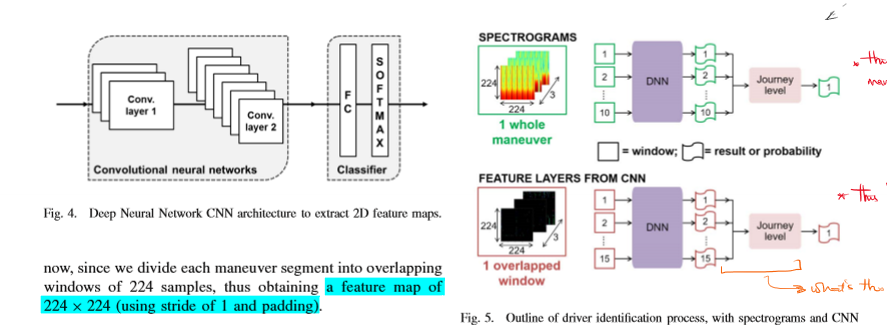

Get only the records associated with driving

In [35]:
subbed_data_Driver = subbed_data.query('Coarse_label == 5.0').copy()
subbed_data_Driver = subbed_data_Driver.reset_index(drop=True)

Remember that we're taking the different positions as different journeys in this case since that means for one trip, we could have 4 journeys since each user had 4 phones placed at different positions

In [36]:
print('Number of unique sub_segments')
print(subbed_data_Driver.groupby(['User', 'Segment'])[['Sub_Segment']].nunique()*4) # x4 for the 4 different positions

print('\nCount of data points in each segment')
print(subbed_data_Driver.groupby(['User', 'Segment'])[['Sub_Segment']].count()//4) # divided by 4 since we want to look at data pts for each position to

Number of unique sub_segments
               Sub_Segment
User  Segment             
User1 5                 24
      7                 20
      9                  8
User2 64                48
      66                 4
      70                16
      73                16

Count of data points in each segment
               Sub_Segment
User  Segment             
User1 5                768
      7                640
      9                256
User2 64              1536
      66               128
      70               512
      73               512


Since I would need to pass 224 long vector in and the sub-segments are of length 12, I'll need to join them together. 

**This code might change when I decide to work with a segment that has lotss of data. Will the 224 cover it?**

Edit later on:\
You don't need to pass in a 224 long vector. All you need to do is to split the each journey into 15 windows with 25% overlap. The 224x224 shape will be be created in the CNN layer.

My subsegment for the LSTM needs to be bigger. A vector of size 12 is too too small

-----
Working with the print out above, we have a reasonable amount of data for each journey. The least in this tiny sample is 128 but that'll increase when we use the main dataset. Now we'll combine the subsegments, calculate the window size based on each new comb_segment length so as break the segments into 15 windows with 25% overlap

In [37]:
import itertools

In [38]:
for i, j in itertools.product(subbed_data_Driver['User'].unique(), subbed_data_Driver['Position'].unique()):
      print(i,j)

User1 Bag
User1 Hand
User1 Hips
User1 Torso
User2 Bag
User2 Hand
User2 Hips
User2 Torso


In [39]:
def combine_sequences(subbed_data_Driver):
      '''Combine sub_segments into *segments for each journey. Where journey is defined as a trip for 
      each user at each segment for each position.

      *segments here doesn't represent the original segment since the data was already
      windowed down with overlap previously.
      '''
      combined_sequences = {}
      users = subbed_data_Driver['User'].unique()
      positions = subbed_data_Driver['Position'].unique()

      # iterate through each combination of user and positions
      for user, position in itertools.product(users, positions):
            # subset data
            user_data = subbed_data_Driver.query("User == @user & Position==@position")
            segments = user_data['Segment'].unique()
            # extract all required data for each segment
            for segment in segments:
                  segment_data = user_data.query("Segment == @segment")
                  long_acc = segment_data['long_acc'].values
                  tranv_acc = segment_data['tranv_acc'].values
                  ang_vel = segment_data['ang_vel'].values
                  
                  combined_sequences[(user, position, segment)] = {   
                        'long_acc': long_acc,
                        'tranv_acc': tranv_acc,
                        'ang_vel': ang_vel
                        }
      
      return combined_sequences


Calculate the window size for each combined_sequence and split into 15 windows with 25% overlap

-----
Decided to go back to getting 224 samples per journey because I need a fixed size during convolution

In [40]:
from scipy.interpolate import interp1d

def interpolate_to_length(array, target_length):
      x = np.linspace(0, len(array) - 1, num=len(array))
      f = interp1d(x, array, kind='linear')
      x_new = np.linspace(0, len(array) - 1, num=target_length)
      interpolated_array = f(x_new)
      return interpolated_array

def create_windows(data, window_size, overlap):
      stride = int(window_size * (1 - overlap))
      num_windows = (len(data) - window_size) // stride + 1
      windows = np.array([data[i*stride:i*stride+window_size] for i in range(num_windows)])
      
      if len(windows) == 0:
            return np.array([interpolate_to_length(data, window_size)])

      # Check if the last window covers the end of the array, if not, add the remaining part
      if windows[-1][-1] != data[-1]:
            last_start_index = len(data) - window_size
            last_window = data[last_start_index:]
            if len(last_window) < window_size:
                  last_window = interpolate_to_length(last_window, window_size)
            windows = list(windows)
            windows.append(last_window)

      return np.array(windows)

In [41]:
a = np.arange(0,128)
windows = create_windows(a, window_size=224, overlap=0.25)

for i,j in enumerate(windows):
      print(f'{i}: {j[0]}->{j[-1]} \t{len(j)}')

0: 0.0->127.0 	224


In [42]:
def get_windowed_df(subbed_data_Driver, window_size=224, overlap=0.25):
      windowed_data = []
      combined_sequences = combine_sequences(subbed_data_Driver)

      for (user, position, segment), signals in combined_sequences.items():
            long_windows = create_windows(signals['long_acc'], window_size, overlap)
            tranv_windows = create_windows(signals['tranv_acc'], window_size, overlap)
            ang_vel_windows = create_windows(signals['ang_vel'], window_size, overlap)

            for i in range(long_windows.shape[0]):
                  windowed_data.append({
                        'user': user,
                        'segment': segment,
                        'position': position,
                        'window_index': i,
                        'long_acc_window': long_windows[i],
                        'tranv_acc_window': tranv_windows[i],
                        'ang_vel_window': ang_vel_windows[i]
                  })

      return pd.DataFrame(windowed_data)

In [43]:
windowed_df = get_windowed_df(subbed_data_Driver)

In [44]:
windowed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user              108 non-null    object
 1   segment           108 non-null    int64 
 2   position          108 non-null    object
 3   window_index      108 non-null    int64 
 4   long_acc_window   108 non-null    object
 5   tranv_acc_window  108 non-null    object
 6   ang_vel_window    108 non-null    object
dtypes: int64(2), object(5)
memory usage: 6.0+ KB


These are the unique window lengths in this dataset

In [45]:
np.unique([len(i) for i in windowed_df['long_acc_window']])

array([224])

Prepare the input for CNN

In [46]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split

In [47]:
class SignalsDataset(Dataset):
      def __init__(self, data, labels, feature_index):
            """
            Args:
                  data (numpy.ndarray): The input data of shape (num_samples, num_features, window_size).
                  labels (numpy.ndarray): The labels for the data of shape (num_samples,).
                  feature_index (int): Index of the feature to use.
            """
            self.data = data[:, feature_index, :]  # Select the specified feature
            self.labels = labels

      def __len__(self):
            return len(self.data)

      def __getitem__(self, idx):
            x = torch.tensor(self.data[idx], dtype=torch.float32).unsqueeze(0)  # Add channel dimension
            y = torch.tensor(self.labels[idx], dtype=torch.long)
            return x, y

In [48]:
def prep_input_for_CNN(windowed_df):
      X = []
      y = []

      for index, row in windowed_df.iterrows():
            long_acc_window = row['long_acc_window']
            tranv_acc_window = row['tranv_acc_window']
            ang_vel_window = row['ang_vel_window']
            combined_window = np.stack([long_acc_window, tranv_acc_window, ang_vel_window], axis=0)
            X.append(combined_window)
            y.append(row['user'])

      X = np.array(X)
      y_lab = np.array(y)
      _, y = np.unique(y_lab, return_inverse=True)
      return X, y

In [291]:
X, y = prep_input_for_CNN(windowed_df)

In [292]:
X.shape

(108, 3, 224)

In [293]:
# Check the first row, long_acc_window of both X and dataframe to see if there's a difference
np.sum(X[0][0] != windowed_df['long_acc_window'][0])

0

In [294]:
# X.shape = (num_samples, channels (3), 224)
# y.shape = (num_samples, )
print(X.shape)
print(y.shape)

(108, 3, 224)
(108,)


In [295]:
np.bincount(y)

array([44, 64], dtype=int64)

In [296]:
# Perform a train-test split
np.random.seed(1)
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_tr, y_tr, test_size=0.2, stratify=y_tr)

# normalizing X
mean = X_train.mean(axis=(0, 2), keepdims=True)
std = X_train.std(axis=(0, 2), keepdims=True)

X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std
X_test = (X_test - mean) / std

In [297]:
# Create datasets for each feature
feature_indices = {'long_acc': 0, 'tranv_acc': 1, 'ang_vel': 2}

train_datasets = {feature: SignalsDataset(X_train, y_train, idx) for feature, idx in feature_indices.items()}
valid_datasets = {feature: SignalsDataset(X_valid, y_valid, idx) for feature, idx in feature_indices.items()}
test_datasets = {feature: SignalsDataset(X_test, y_test, idx) for feature, idx in feature_indices.items()}

In [298]:
train_datasets

{'long_acc': <__main__.SignalsDataset at 0x24488a4ec20>,
 'tranv_acc': <__main__.SignalsDataset at 0x24488a4d8d0>,
 'ang_vel': <__main__.SignalsDataset at 0x2448915e140>}

In [299]:
np.random.seed(1)

batch_size = 1
train_dl_long = DataLoader(train_datasets['long_acc'], batch_size, shuffle=True)
train_dl_tranv = DataLoader(train_datasets['tranv_acc'], batch_size, shuffle=True)
train_dl_angvel = DataLoader(train_datasets['ang_vel'], batch_size, shuffle=True)

valid_dl_long = DataLoader(valid_datasets['long_acc'], batch_size, shuffle=False)
valid_dl_tranv = DataLoader(valid_datasets['tranv_acc'], batch_size, shuffle=False)
valid_dl_angvel = DataLoader(valid_datasets['ang_vel'], batch_size, shuffle=False)

test_dl_long = DataLoader(test_datasets['long_acc'], batch_size, shuffle=False)
test_dl_tranv = DataLoader(test_datasets['tranv_acc'], batch_size, shuffle=False)
test_dl_angvel = DataLoader(test_datasets['ang_vel'], batch_size, shuffle=False)

In [300]:
# Check the shape of the data in DataLoader
for x, y in train_dl_long:
    print(x.shape)  # Expected: torch.Size([1, 1, 224])
    print(y.shape)  # Expected: torch.Size([1])
    break  # Only check the first batch

torch.Size([1, 1, 224])
torch.Size([1])


Simple CNN model

In [301]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Going back above to make sure my data is in this format;

`conv1d()` takes `[Batch_size, Channels_in, Length]` and outputs `[Batch_size, Channels_out, Length_out]`\
`conv2d()` takes `[Batch_size, Channels_in, H, W]` and outputs `[Batch_size, Channels_out, H_out, W_out]`

In [432]:
class SimpleCNN(nn.Module):
      def __init__(self):
            super(SimpleCNN, self).__init__()
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=224, kernel_size=3, padding=1)
            self.conv2 = nn.Conv2d(in_channels=224, out_channels=224, kernel_size=3, padding=1)
            self.flatten = nn.Flatten()
            self.fc = nn.Linear(224 * 224, 1)  # Fully connected layer for classification

      def forward(self, x):
            x = F.relu(self.conv1(x))  # Apply ReLU activation after Conv1d
            x = x.unsqueeze(2) # Add dimension for Conv2d: (batch_size, channels, 1, length)
            x = F.relu(self.conv2(x))  # Apply ReLU activation after Conv2d
            x = self.flatten(x)  # Flatten the tensor
            x = self.fc(x)  # Fully connected layer
            x = F.sigmoid(x)
            return x

In [351]:
model_long = SimpleCNN()
model_tranv = SimpleCNN()
model_ang = SimpleCNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_long = model_long.to(device)
model_tranv = model_tranv.to(device)
model_ang = model_ang.to(device)


loss_fn = nn.BCELoss()

optimizer_long = torch.optim.SGD(model_long.parameters(), lr=0.0001)
optimizer_tranv = torch.optim.SGD(model_tranv.parameters(), lr=0.001)
optimizer_ang = torch.optim.SGD(model_ang.parameters(), lr=0.0001)

Define training function

In [352]:
def train(model, optimizer, num_epochs, train_dl, valid_dl, save_path=None):
      loss_hist_train = [0] * num_epochs
      accuracy_hist_train = [0] * num_epochs
      loss_hist_valid = [0] * num_epochs
      accuracy_hist_valid = [0] * num_epochs

      for epoch in range(num_epochs):
            model.train()
            for x_batch, y_batch in train_dl:
                  x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                  pred = model(x_batch)[:, 0]
                  loss = loss_fn(pred, y_batch.float())
                  loss.backward()
                  optimizer.step()
                  optimizer.zero_grad()
                  loss_hist_train[epoch] += loss.item()*y_batch.size(0)
                  is_correct = ((pred>=0.5).float() == y_batch).float()
                  accuracy_hist_train[epoch] += is_correct.sum().cpu()
            loss_hist_train[epoch] /= len(train_dl.dataset)
            accuracy_hist_train[epoch] /= len(train_dl.dataset)

            model.eval()
            with torch.no_grad():
                  for x_batch, y_batch in valid_dl:
                        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                        pred = model(x_batch)[:, 0]
                        loss = loss_fn(pred, y_batch.float())
                        loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                        is_correct = ((pred>=0.5).float() == y_batch).float()
                        accuracy_hist_valid[epoch] += is_correct.sum().cpu()
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

            print(f'Epoch {epoch+1} accuracy: '
                  f'{accuracy_hist_train[epoch]:.4f} val_accuracy: '
                  f'{accuracy_hist_valid[epoch]:.4f}')
            
      # Save checkpoint
      if save_path:
            #save_path = 'model_checkpoint.pth'
            torch.save({
                  #'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': loss,
            }, save_path)
            
      return loss_hist_train, loss_hist_valid, \
            accuracy_hist_train, accuracy_hist_valid


In [353]:
torch.manual_seed(1)
num_epochs = 30

long_hist = train(model_long, optimizer_long, num_epochs, train_dl_long, valid_dl_long, save_path='model_long2d.pth')

Epoch 1 accuracy: 0.5441 val_accuracy: 0.6111
Epoch 2 accuracy: 0.5882 val_accuracy: 0.6111
Epoch 3 accuracy: 0.6176 val_accuracy: 0.6111
Epoch 4 accuracy: 0.5882 val_accuracy: 0.6111
Epoch 5 accuracy: 0.5882 val_accuracy: 0.6111
Epoch 6 accuracy: 0.5882 val_accuracy: 0.6111
Epoch 7 accuracy: 0.5882 val_accuracy: 0.6111
Epoch 8 accuracy: 0.5882 val_accuracy: 0.5556
Epoch 9 accuracy: 0.6471 val_accuracy: 0.6111
Epoch 10 accuracy: 0.5882 val_accuracy: 0.6111
Epoch 11 accuracy: 0.6029 val_accuracy: 0.6667
Epoch 12 accuracy: 0.6471 val_accuracy: 0.6667
Epoch 13 accuracy: 0.5882 val_accuracy: 0.6111
Epoch 14 accuracy: 0.6176 val_accuracy: 0.6111
Epoch 15 accuracy: 0.6618 val_accuracy: 0.6111
Epoch 16 accuracy: 0.6176 val_accuracy: 0.7222
Epoch 17 accuracy: 0.6765 val_accuracy: 0.6667
Epoch 18 accuracy: 0.6471 val_accuracy: 0.6667
Epoch 19 accuracy: 0.6324 val_accuracy: 0.7222
Epoch 20 accuracy: 0.6471 val_accuracy: 0.7222
Epoch 21 accuracy: 0.6618 val_accuracy: 0.7222
Epoch 22 accuracy: 0.6

In [354]:
torch.manual_seed(1)
num_epochs = 30

tranv_hist = train(model_tranv, optimizer_tranv, num_epochs, train_dl_tranv, valid_dl_tranv, save_path='model_tranv2d.pth')

Epoch 1 accuracy: 0.4412 val_accuracy: 0.6111
Epoch 2 accuracy: 0.5147 val_accuracy: 0.6111
Epoch 3 accuracy: 0.5441 val_accuracy: 0.6111
Epoch 4 accuracy: 0.5588 val_accuracy: 0.6111
Epoch 5 accuracy: 0.5588 val_accuracy: 0.6111
Epoch 6 accuracy: 0.5441 val_accuracy: 0.6111
Epoch 7 accuracy: 0.5294 val_accuracy: 0.6111
Epoch 8 accuracy: 0.5588 val_accuracy: 0.6111
Epoch 9 accuracy: 0.6324 val_accuracy: 0.6111
Epoch 10 accuracy: 0.5735 val_accuracy: 0.6111
Epoch 11 accuracy: 0.5735 val_accuracy: 0.6111
Epoch 12 accuracy: 0.6324 val_accuracy: 0.6111
Epoch 13 accuracy: 0.6618 val_accuracy: 0.6111
Epoch 14 accuracy: 0.6176 val_accuracy: 0.5000
Epoch 15 accuracy: 0.5441 val_accuracy: 0.6111
Epoch 16 accuracy: 0.6176 val_accuracy: 0.6667
Epoch 17 accuracy: 0.6471 val_accuracy: 0.6111
Epoch 18 accuracy: 0.6324 val_accuracy: 0.6111
Epoch 19 accuracy: 0.7059 val_accuracy: 0.5556
Epoch 20 accuracy: 0.6765 val_accuracy: 0.6667
Epoch 21 accuracy: 0.6471 val_accuracy: 0.6667
Epoch 22 accuracy: 0.6

In [355]:
torch.manual_seed(1)
num_epochs = 30

ang_hist = train(model_ang, optimizer_ang, num_epochs, train_dl_angvel, valid_dl_angvel, save_path='model_angvel2d.pth')

Epoch 1 accuracy: 0.5294 val_accuracy: 0.6111
Epoch 2 accuracy: 0.5882 val_accuracy: 0.6111
Epoch 3 accuracy: 0.5882 val_accuracy: 0.6111
Epoch 4 accuracy: 0.5882 val_accuracy: 0.6111
Epoch 5 accuracy: 0.5882 val_accuracy: 0.6111
Epoch 6 accuracy: 0.5882 val_accuracy: 0.6111
Epoch 7 accuracy: 0.6029 val_accuracy: 0.6111
Epoch 8 accuracy: 0.6176 val_accuracy: 0.6111
Epoch 9 accuracy: 0.6324 val_accuracy: 0.6111
Epoch 10 accuracy: 0.6324 val_accuracy: 0.6111
Epoch 11 accuracy: 0.6324 val_accuracy: 0.6111
Epoch 12 accuracy: 0.6618 val_accuracy: 0.6111
Epoch 13 accuracy: 0.6618 val_accuracy: 0.6111
Epoch 14 accuracy: 0.6765 val_accuracy: 0.5556
Epoch 15 accuracy: 0.6912 val_accuracy: 0.5556
Epoch 16 accuracy: 0.6618 val_accuracy: 0.5556
Epoch 17 accuracy: 0.7059 val_accuracy: 0.5556
Epoch 18 accuracy: 0.7059 val_accuracy: 0.5556
Epoch 19 accuracy: 0.7059 val_accuracy: 0.5556
Epoch 20 accuracy: 0.7059 val_accuracy: 0.5556
Epoch 21 accuracy: 0.7059 val_accuracy: 0.5556
Epoch 22 accuracy: 0.7

In [356]:
import matplotlib.pyplot as plt

In [357]:
def plot_history(hist):
      x_arr = np.arange(len(hist[0])) + 1

      fig = plt.figure(figsize=(12, 4))
      ax = fig.add_subplot(1, 2, 1)
      ax.plot(x_arr, hist[0], '-o', label='Train loss')
      ax.plot(x_arr, hist[1], '--<', label='Validation loss')
      ax.legend(fontsize=15)
      ax.set_xlabel('Epoch', size=15)
      ax.set_ylabel('Loss', size=15)

      ax = fig.add_subplot(1, 2, 2)
      ax.plot(x_arr, hist[2], '-o', label='Train acc.')
      ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
      ax.legend(fontsize=15)
      ax.set_xlabel('Epoch', size=15)
      ax.set_ylabel('Accuracy', size=15)

      #plt.savefig('figures/14_17.png', dpi=300)
      plt.show()

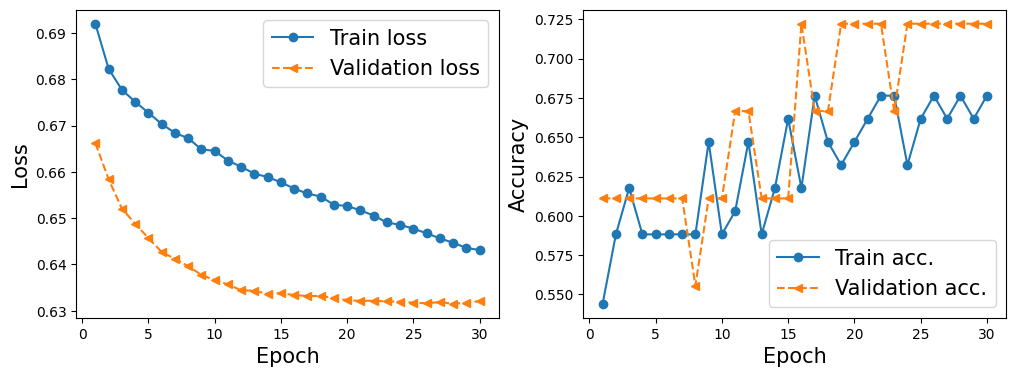

In [358]:
plot_history(long_hist)

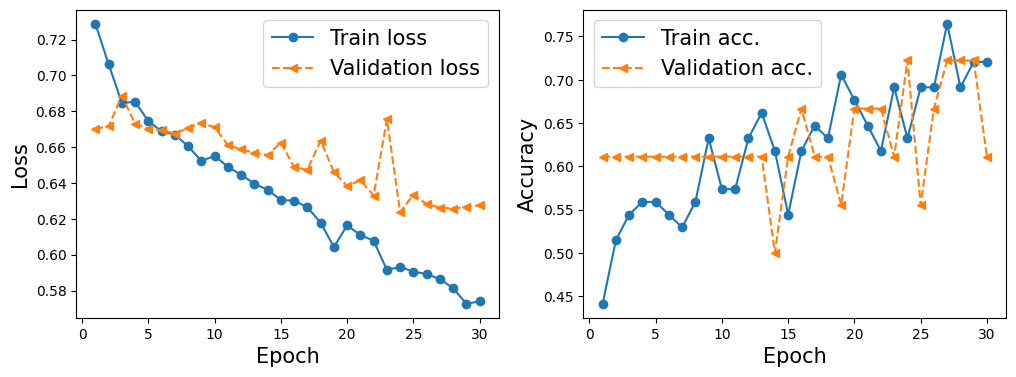

In [359]:
plot_history(tranv_hist)

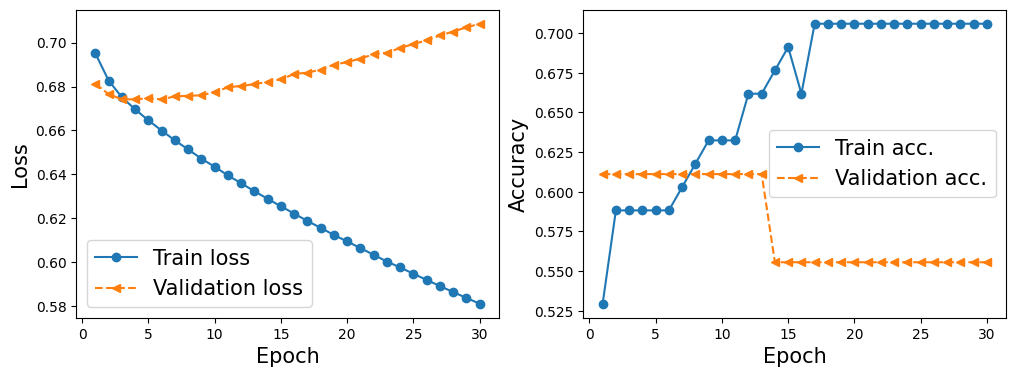

In [360]:
plot_history(ang_hist)

Probably would be better when we have more data. Currently, our training data and validation is small.

---

### Test Phase

In [379]:
len(X_train)

68

In [390]:
### Test Phase

In [389]:
correct_agreements = 0
total_samples = 0

# Iterate through the test data loaders simultaneously
for (x_long, y_long), (x_tranv, y_tranv), (x_angvel, y_angvel) in zip(test_dl_long, test_dl_tranv, test_dl_angvel):
      # Transfer data to device
      x_long, y_long = x_long.to(device), y_long.to(device)
      x_tranv, y_tranv = x_tranv.to(device), y_tranv.to(device)
      x_angvel, y_angvel = x_angvel.to(device), y_angvel.to(device)

      # Assuming each model outputs probabilities (sigmoid output)
      with torch.no_grad():
            pred_long = model_long(x_long)
            pred_tranv = model_tranv(x_tranv)
            pred_angvel = model_ang(x_angvel)

      # Combine predictions (average probabilities)
      pred_combined = (pred_long + pred_tranv + pred_angvel) / 3

      # Apply threshold (convert probabilities to binary predictions)
      pred_label = (pred_combined > 0.5).float()  # 1 if probability > 0.5, else 0

      # Compare with ground truth label y_long (assuming all y_long, y_tranv, y_angvel are the same for a sample)
      correct_agreements += torch.sum(pred_label == y_long).item()

      total_samples += x_long.size(0)  # Increment total samples processed

# Calculate accuracy
accuracy = correct_agreements / total_samples
print(f"Agreement accuracy among models: {accuracy}")


Agreement accuracy among models: 0.6363636363636364


In [392]:
total_samples

22

### Feature Map Extraction

In [564]:
# Function to extract feature map
def get_feature_map(model, x_batch):
      # Place model in evaluation mode
      model.eval()
      
      # Hook to store the feature map
      feature_maps = []

      # Define a hook function to capture the feature map
      def hook(module, input, output):
            feature_maps.append(output.detach().cpu().numpy())

      # Register the hook to the desired layer
      hook_handle = model.conv2.register_forward_hook(hook)

      try:
            # Run the data through the model to trigger the hook
            with torch.no_grad():
                  model(x_batch)
      finally:
            # Remove the hook after feature extraction
            hook_handle.remove()

      return feature_maps[0]


def feature_map_extractor(model, dataloader):
      '''Extracts the feature maps from the model and returns it as well as the corresponding labels'''
      feature_maps_list = []
      y_lab = []

      for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            f_maps = get_feature_map(model, x_batch)
            
            # Append feature maps and labels
            feature_maps_list.append(f_maps)
            y_lab.append(y_batch.numpy())

      # Concatenate all feature maps and labels into single arrays
      feature_maps_array = np.concatenate(feature_maps_list, axis=0)
      y_lab_array = np.concatenate(y_lab, axis=0)

      return feature_maps_array, y_lab_array

In [458]:
# test_model = SimpleCNN()
# test_model = test_model.to(device)
# input_data = next(iter(train_dl_long))[0].to(device)

In [515]:
# # Get the feature map
# feature_map = get_feature_map(model_long, input_data)

# # Display processed feature maps shape
# print(f"Processed feature map shape: {feature_map.shape}")

Processed feature map shape: (1, 224, 1, 224)


In [516]:
import seaborn as sns

# Normalize the feature maps to [0, 1] range for visualization
def normalize_feature_map(feature_map):
      feature_map_min = feature_map.min(axis=(2, 3), keepdims=True)
      feature_map_max = feature_map.max(axis=(2, 3), keepdims=True)
      normalized_feature_map = (feature_map - feature_map_min) / (feature_map_max - feature_map_min + 1e-8)
      return normalized_feature_map

# visualize feature map
def feature_map_heatmap(feature_map, cmap='viridis'):
      normalized_feature_map = normalize_feature_map(feature_map)

      sns.heatmap(np.squeeze(normalized_feature_map), cmap='viridis')

In [ ]:
## setting shuffle = False as I want to long, tranv and angvel to correspond
train_dl_long = DataLoader(train_datasets['long_acc'], batch_size, shuffle=False)
train_dl_tranv = DataLoader(train_datasets['tranv_acc'], batch_size, shuffle=False)
train_dl_angvel = DataLoader(train_datasets['ang_vel'], batch_size, shuffle=False)

valid_dl_long = DataLoader(valid_datasets['long_acc'], batch_size, shuffle=False)
valid_dl_tranv = DataLoader(valid_datasets['tranv_acc'], batch_size, shuffle=False)
valid_dl_angvel = DataLoader(valid_datasets['ang_vel'], batch_size, shuffle=False)

test_dl_long = DataLoader(test_datasets['long_acc'], batch_size, shuffle=False)
test_dl_tranv = DataLoader(test_datasets['tranv_acc'], batch_size, shuffle=False)
test_dl_angvel = DataLoader(test_datasets['ang_vel'], batch_size, shuffle=False)

In [591]:
long_dl = [train_dl_long, valid_dl_long, test_dl_long]
tranv_dl = [train_dl_tranv, valid_dl_tranv, test_dl_tranv]
angvel_dl = [train_dl_angvel, valid_dl_angvel, test_dl_angvel]

fmaps_long = []
fmaps_tranv = []
fmaps_angvel = []

for dl in long

{'long_acc': <__main__.SignalsDataset at 0x24488a4ec20>,
 'tranv_acc': <__main__.SignalsDataset at 0x24488a4d8d0>,
 'ang_vel': <__main__.SignalsDataset at 0x2448915e140>}